In [0]:
import pandas as pd
import numpy as np

In [0]:
%cd /content/drive/My\ Drive/creative-cooking/
import creative_cooking as creative_cook

/content/drive/My Drive/creative-cooking


In [0]:
df_users = creative_cook.read_data_files('PP_users')
# df_rec = creative_cook.read_data_files('PP_recipes')
df_rec_raw = creative_cook.read_data_files('RAW_recipes')
# df_int_raw = creative_cook.read_data_files('RAW_interactions')

In [0]:
df_desired_tags = pd.read_csv('data/desired_tags.csv')
print(df_desired_tags.shape)
df_desired_tags = df_desired_tags[df_desired_tags.keep == 1]
print(df_desired_tags.shape)

(552, 3)
(286, 3)


In [0]:
import statistics
from scipy import stats as s

In [0]:
df_users['avg_rating'] = df_users['ratings'].apply(lambda x: creative_cook.parse_array(x, np.mean))
df_users['mode_rating'] = df_users['ratings'].apply(lambda x: int(creative_cook.parse_array(x, s.mode)[0]))
df_users['var_rating'] = df_users['ratings'].apply(lambda x: creative_cook.parse_array(x, statistics.variance))

In [0]:
df_users.head()

,u,techniques,items,n_items,ratings,n_ratings,avg_rating,mode_rating,var_rating
0,0,"[8, 0, 0, 5, 6, 0, 0, 1, 0, 9, 1, 0, 0, 0, 1, ...","[1118, 27680, 32541, 137353, 16428, 28815, 658...",31,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, ...",31,4.806452,5,0.161290
1,1,"[11, 0, 0, 2, 12, 0, 0, 0, 0, 14, 5, 0, 0, 0, ...","[122140, 77036, 156817, 76957, 68818, 155600, ...",39,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",39,4.948718,5,0.049933
2,2,"[13, 0, 0, 7, 5, 0, 1, 2, 1, 11, 0, 1, 0, 0, 1...","[168054, 87218, 35731, 1, 20475, 9039, 124834,...",27,"[3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, ...",27,4.222222,4,0.256410
3,3,"[498, 13, 4, 218, 376, 3, 2, 33, 16, 591, 10, ...","[163193, 156352, 102888, 19914, 169438, 55772,...",1513,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, ...",1513,4.821547,5,0.236652
4,4,"[161, 1, 1, 86, 93, 0, 0, 11, 2, 141, 0, 16, 0...","[72857, 38652, 160427, 55772, 119999, 141777, ...",376,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 4.0, 5.0, ...",376,4.388298,5,0.910156


In [0]:
from IPython.display import display, HTML

In [0]:
def split_tags(df, tag_list, users_to_rec):
  users_to_rec.recipe_id = users_to_rec.recipe_id.astype(int)
  df.id = df.id.astype(int)
  print(users_to_rec.head())
  print(df.head())
  df = users_to_rec.merge(df[['tags', 'id']],  how='left', left_on=['recipe_id'], right_on=['id']).fillna('')
  display(df.head())
  lst_col = 'tags'

  s = df.apply(lambda x: pd.Series(x['tags'].replace('[','').replace(']','').replace(' ', '').replace("'", "").replace('__', '_').replace(':', '').split(',')),axis=1)\
              .stack().reset_index(level=1, drop=True)
  s.name = 'tag'
  table_needed = df.join(s)[['u', 'tag']]
  del s
  table_needed = table_needed[table_needed.tag.isin(tag_list)]
  table_needed = pd.get_dummies(table_needed, prefix_sep="__",
                              columns=['tag']).groupby('u').mean().reset_index()
  # pd.DataFrame(table_needed).to_csv('/content/drive/My\ Drive/creative-cooking/data/ohe_tags_by_user.csv', index=True)
  return table_needed

In [0]:
users_to_rec = df_users.apply(lambda x: pd.Series(x['items'].replace('[','').replace(']','').split(',')),axis=1).stack().reset_index(level=1, drop=True)
users_to_rec.name = 'recipe_id'
users_to_rec=df_users.join(users_to_rec)[['u', 'recipe_id']]
users_to_rec.head()

,u,recipe_id
0,0,1118
0,0,27680
0,0,32541
0,0,137353
0,0,16428


In [0]:
df_rec_raw.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [0]:
# %%time
# table_needed = split_tags(df_rec_raw, df_desired_tags.tag.unique(), users_to_rec)
# took 4 minutes
table_needed = pd.read_csv('data/ohe_tags_by_user.csv')

In [0]:
table_needed.shape

(23880, 286)

In [0]:
table_needed.columns

Index(['Unnamed: 0', 'u', 'tag__1-day-or-more', 'tag__15-minutes-or-less',
       'tag__3-steps-or-less', 'tag__30-minutes-or-less',
       'tag__4-hours-or-less', 'tag__5-ingredients-or-less',
       'tag__60-minutes-or-less', 'tag__african',
       ...
       'tag__vegetarian', 'tag__very-low-carbs', 'tag__vietnamese',
       'tag__water-bath', 'tag__weeknight', 'tag__whole-chicken',
       'tag__whole-turkey', 'tag__winter', 'tag__yams-sweet-potatoes',
       'tag__yeast'],
      dtype='object', length=286)

In [0]:
table_needed = table_needed.drop(['Unnamed: 0'], axis=1)
table_needed.head()

,u,tag__1-day-or-more,tag__15-minutes-or-less,tag__3-steps-or-less,tag__30-minutes-or-less,tag__4-hours-or-less,tag__5-ingredients-or-less,tag__60-minutes-or-less,tag__african,tag__american,tag__appetizers,tag__apples,tag__argentine,tag__asian,tag__asparagus,tag__australian,tag__bacon,tag__bananas,tag__bar-cookies,tag__barbecue,tag__beans,tag__beef,tag__beef-ribs,tag__beef-sausage,tag__beginner-cook,tag__berries,tag__beverages,tag__bisques-cream-soups,tag__black-beans,tag__brazilian,tag__breads,tag__breakfast,tag__broccoli,tag__broil,tag__brown-bag,tag__brunch,tag__burgers,tag__cajun,tag__cake-fillings-and-frostings,tag__cakes,...,tag__squash,tag__st-patricks-day,tag__steak,tag__steaks,tag__stews,tag__stir-fry,tag__stove-top,tag__strawberries,tag__summer,tag__super-bowl,tag__superbowl,tag__swedish,tag__sweet,tag__swiss,tag__taste-mood,tag__tex-mex,tag__thai,tag__thanksgiving,tag__tilapia,tag__to-go,tag__toddler-friendly,tag__tomatoes,tag__tropical-fruit,tag__tuna,tag__turkey,tag__turkish,tag__valentines-day,tag__veal,tag__vegan,tag__vegetables,tag__vegetarian,tag__very-low-carbs,tag__vietnamese,tag__water-bath,tag__weeknight,tag__whole-chicken,tag__whole-turkey,tag__winter,tag__yams-sweet-potatoes,tag__yeast
0,0,0.000000,0.013636,0.018182,0.013636,0.013636,0.009091,0.027273,0.000000,0.018182,0.000000,0.004545,0.0,0.009091,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009091,0.000000,0.000000,0.013636,0.004545,0.004545,0.000000,0.000000,0.0,0.004545,0.009091,0.000000,0.000000,0.009091,0.004545,0.0,0.000000,0.000000,0.004545,...,0.000000,0.000000,0.000000,0.004545,0.000000,0.000000,0.004545,0.000000,0.009091,0.000000,0.000000,0.0,0.004545,0.000000,0.018182,0.000000,0.000000,0.004545,0.000000,0.018182,0.000000,0.004545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004545,0.022727,0.013636,0.004545,0.0,0.000000,0.000000,0.004545,0.000000,0.000000,0.000000,0.000000
1,1,0.000000,0.012097,0.016129,0.024194,0.016129,0.004032,0.024194,0.000000,0.008065,0.008065,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004032,0.012097,0.016129,0.000000,0.000000,0.024194,0.004032,0.000000,0.000000,0.000000,0.0,0.004032,0.004032,0.004032,0.000000,0.004032,0.000000,0.0,0.000000,0.000000,0.004032,...,0.000000,0.000000,0.004032,0.000000,0.004032,0.000000,0.008065,0.000000,0.000000,0.000000,0.000000,0.0,0.004032,0.000000,0.004032,0.004032,0.000000,0.000000,0.000000,0.008065,0.004032,0.004032,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016129,0.004032,0.004032,0.0,0.000000,0.012097,0.000000,0.000000,0.008065,0.000000,0.004032
2,2,0.000000,0.010870,0.010870,0.010870,0.021739,0.000000,0.016304,0.000000,0.032609,0.005435,0.000000,0.0,0.005435,0.000000,0.000000,0.000000,0.010870,0.000000,0.005435,0.005435,0.005435,0.000000,0.000000,0.010870,0.000000,0.005435,0.005435,0.000000,0.0,0.010870,0.000000,0.000000,0.000000,0.005435,0.005435,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.005435,0.000000,0.005435,0.000000,0.010870,0.000000,0.000000,0.0,0.005435,0.000000,0.032609,0.005435,0.000000,0.000000,0.000000,0.021739,0.000000,0.005435,0.010870,0.000000,0.000000,0.000000,0.000000,0.000000,0.005435,0.027174,0.016304,0.000000,0.0,0.000000,0.005435,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0.000905,0.012430,0.009796,0.016958,0.015887,0.012595,0.022473,0.000576,0.011525,0.006174,0.001399,0.0,0.004116,0.000494,0.001235,0.000412,0.000823,0.001646,0.001646,0.002881,0.006338,0.000247,0.000247,0.010701,0.001729,0.002881,0.000412,0.000659,0.0,0.005927,0.004857,0.000494,0.001070,0.001646,0.007162,0.0,0.000165,0.000576,0.003787,...,0.000988,0.000494,0.000165,0.000329,0.000329,0.000988,0.011771,0.000905,0.003540,0.000000,0.000905,0.0,0.004198,0.000082,0.020497,0.000329,0.000412,0.001235,0.000082,0.008232,0.001893,0.001646,0.002140,0.000576,0.000741,0.000165,0.001317,0.000000,0.002223,0.019015,0.011113,0.003046,0.0,0.000247,0.007820,0.000165,0.000082,0.002716,0.000494,0.000

In [0]:
def get_nutrition(df, users_to_rec):

  nut = pd.DataFrame()
  nut['id']=df['id']
  nut['cals'] = df['nutrition'].apply(lambda x: creative_cook.parse_array_w_index(x, 0))
  nut['perc_d_fat'] = df['nutrition'].apply(lambda x: creative_cook.parse_array_w_index(x, 1))
  nut['perc_d_sugar'] = df['nutrition'].apply(lambda x: creative_cook.parse_array_w_index(x, 2))
  nut['perc_d_sodium'] = df['nutrition'].apply(lambda x: creative_cook.parse_array_w_index(x, 3))
  nut['perc_d_protein'] = df['nutrition'].apply(lambda x: creative_cook.parse_array_w_index(x, 4))
  nut['perc_d_sat_fat'] = df['nutrition'].apply(lambda x: creative_cook.parse_array_w_index(x, 5))
  nut['perc_d_carbs'] = df['nutrition'].apply(lambda x: creative_cook.parse_array_w_index(x, 6))
  nut['minutes'] = df['minutes']
  nut['n_steps'] = df['n_steps']

  users_to_rec.recipe_id = users_to_rec.recipe_id.astype(int)
  nut.id = nut.id.astype(int)

  df_user_to_rec = users_to_rec.merge(nut,  how='left', left_on=['recipe_id'], right_on=['id']).drop('id', axis=1)

  df_user_to_rec_grouped = df_user_to_rec.groupby('u')[df_user_to_rec.columns[2:]].mean().reset_index()
  return df_user_to_rec_grouped

In [0]:
df_user_to_rec_grouped = get_nutrition(df_rec_raw, users_to_rec)

In [0]:
df_user_to_rec_grouped.head()

,u,cals,perc_d_fat,perc_d_sugar,perc_d_sodium,perc_d_protein,perc_d_sat_fat,perc_d_carbs,minutes,n_steps
0,0,454.553333,33.666667,66.666667,39.466667,35.200000,53.200000,15.066667,46.800000,8.466667
1,1,437.495238,38.142857,50.190476,29.333333,32.904762,43.714286,11.761905,127.142857,9.619048
2,2,530.708333,42.166667,97.166667,36.416667,30.500000,56.416667,18.416667,80.000000,9.000000
3,3,527.191304,40.533181,93.205950,36.075515,40.344394,51.144165,17.060641,190.053776,9.379863
4,4,548.589573,40.189573,111.545024,30.355450,41.023697,48.658768,18.587678,297.876777,9.374408


In [0]:
df_for_clustering = df_users[['u', 'avg_rating', 'mode_rating', 'var_rating']].merge(df_user_to_rec_grouped, on='u', how='left').fillna(0)


In [0]:
df_for_clustering.head()

,u,avg_rating,mode_rating,var_rating,cals,perc_d_fat,perc_d_sugar,perc_d_sodium,perc_d_protein,perc_d_sat_fat,perc_d_carbs,minutes,n_steps
0,0,4.806452,5,0.161290,454.553333,33.666667,66.666667,39.466667,35.200000,53.200000,15.066667,46.800000,8.466667
1,1,4.948718,5,0.049933,437.495238,38.142857,50.190476,29.333333,32.904762,43.714286,11.761905,127.142857,9.619048
2,2,4.222222,4,0.256410,530.708333,42.166667,97.166667,36.416667,30.500000,56.416667,18.416667,80.000000,9.000000
3,3,4.821547,5,0.236652,527.191304,40.533181,93.205950,36.075515,40.344394,51.144165,17.060641,190.053776,9.379863
4,4,4.388298,5,0.910156,548.589573,40.189573,111.545024,30.355450,41.023697,48.658768,18.587678,297.876777,9.374408


In [0]:
df_for_clustering = df_for_clustering.merge(table_needed, on='u', how='left').fillna(0)

In [0]:
df_for_clustering.shape

(25076, 297)

In [0]:
from sklearn import preprocessing
def min_max_normalize(df_copy, list_columns):
    df_label_vals = pd.DataFrame(columns = ['var' , 'min', 'max'])
    for col in list_columns:
        df_label_vals = df_label_vals.append({'var' : col , 'min' : np.min(df_copy[col]), 'max' : np.max(df_copy[col])} , ignore_index=True)
        x = df_copy[col].values.reshape(-1, 1) #returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        df_copy[col] = pd.DataFrame(x_scaled)
    return df_copy, df_label_vals

In [0]:
df_for_clustering_norm, df_label_stats = min_max_normalize(df_for_clustering, list(df_for_clustering.columns[df_for_clustering.columns.isin(['u'])==False]))

In [0]:
df_label_stats.head()

,var,min,max
0,avg_rating,0.0,5.0
1,mode_rating,0.0,5.0
2,var_rating,0.0,12.5
3,cals,0.0,21619.6
4,perc_d_fat,0.0,1184.5


In [0]:
df_for_clustering_norm.head()

,u,avg_rating,mode_rating,var_rating,cals,perc_d_fat,perc_d_sugar,perc_d_sodium,perc_d_protein,perc_d_sat_fat,perc_d_carbs,minutes,n_steps,tag__1-day-or-more,tag__15-minutes-or-less,tag__3-steps-or-less,tag__30-minutes-or-less,tag__4-hours-or-less,tag__5-ingredients-or-less,tag__60-minutes-or-less,tag__african,tag__american,tag__appetizers,tag__apples,tag__argentine,tag__asian,tag__asparagus,tag__australian,tag__bacon,tag__bananas,tag__bar-cookies,tag__barbecue,tag__beans,tag__beef,tag__beef-ribs,tag__beef-sausage,tag__beginner-cook,tag__berries,tag__beverages,tag__bisques-cream-soups,...,tag__squash,tag__st-patricks-day,tag__steak,tag__steaks,tag__stews,tag__stir-fry,tag__stove-top,tag__strawberries,tag__summer,tag__super-bowl,tag__superbowl,tag__swedish,tag__sweet,tag__swiss,tag__taste-mood,tag__tex-mex,tag__thai,tag__thanksgiving,tag__tilapia,tag__to-go,tag__toddler-friendly,tag__tomatoes,tag__tropical-fruit,tag__tuna,tag__turkey,tag__turkish,tag__valentines-day,tag__veal,tag__vegan,tag__vegetables,tag__vegetarian,tag__very-low-carbs,tag__vietnamese,tag__water-bath,tag__weeknight,tag__whole-chicken,tag__whole-turkey,tag__winter,tag__yams-sweet-potatoes,tag__yeast
0,0,0.961290,1.0,0.012903,0.021025,0.028423,0.013915,0.004179,0.032000,0.029955,0.012994,0.000542,0.148538,0.000000,0.027273,0.072727,0.013636,0.027273,0.027273,0.054545,0.000000,0.072727,0.000000,0.022727,0.0,0.027273,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036364,0.000000,0.000000,0.068182,0.027273,0.009091,0.000000,...,0.000000,0.000000,0.000000,0.022727,0.000000,0.000000,0.027273,0.000000,0.072727,0.000000,0.000000,0.0,0.031818,0.000000,0.109091,0.000000,0.00000,0.040909,0.000000,0.127273,0.000000,0.031818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036364,0.045455,0.040909,0.027273,0.0,0.000000,0.000000,0.031818,0.000000,0.000000,0.000000,0.000000
1,1,0.989744,1.0,0.003995,0.020236,0.032202,0.010476,0.003106,0.029913,0.024614,0.010144,0.001472,0.168755,0.000000,0.024194,0.064516,0.024194,0.032258,0.012097,0.048387,0.000000,0.032258,0.016129,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028226,0.048387,0.064516,0.000000,0.000000,0.120968,0.024194,0.000000,0.000000,...,0.000000,0.000000,0.028226,0.000000,0.032258,0.000000,0.048387,0.000000,0.000000,0.000000,0.000000,0.0,0.028226,0.000000,0.024194,0.040323,0.00000,0.000000,0.000000,0.056452,0.020161,0.028226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032258,0.012097,0.024194,0.0,0.000000,0.012097,0.000000,0.000000,0.072581,0.000000,0.012097
2,2,0.844444,0.8,0.020513,0.024548,0.035599,0.020281,0.003856,0.027727,0.031766,0.015883,0.000926,0.157895,0.000000,0.021739,0.043478,0.010870,0.043478,0.000000,0.032609,0.000000,0.130435,0.010870,0.000000,0.0,0.016304,0.000000,0.000000,0.000000,0.076087,0.000000,0.038043,0.021739,0.021739,0.000000,0.000000,0.054348,0.000000,0.010870,0.054348,...,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.032609,0.000000,0.086957,0.000000,0.000000,0.0,0.038043,0.000000,0.195652,0.054348,0.00000,0.000000,0.000000,0.152174,0.000000,0.038043,0.065217,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.054348,0.048913,0.000000,0.0,0.000000,0.005435,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0.964309,1.0,0.018932,0.024385,0.034220,0.019454,0.003820,0.036677,0.028797,0.014714,0.002200,0.164559,0.001811,0.024860,0.039183,0.016958,0.031775,0.037784,0.044946,0.002881,0.046098,0.012348,0.006997,0.0,0.012348,0.001482,0.008643,0.002881,0.005762,0.006585,0.011525,0.011525,0.025354,0.001976,0.001235,0.053507,0.010372,0.005762,0.004116,...,0.003951,0.004445,0.001152,0.001646,0.002634,0.006915,0.070629,0.007244,0.028317,0.000000,0.010866,0.0,0.029388,0.000905,0.122983,0.003293,0.00247,0.011113,0.001152,0.057623,0.009467,0.011525,0.012842,0.002881,0.003704,0.003787,0.011854,0.000000,0.017781,0.038031,0.033339,0.018275,0.0,0.002963,0.007820,0.001152,0.001317,0.024448,0.002963,0.002716
4,4,0.877660,1.0,0.0728

In [0]:
# df_label_stats.to_csv('data/label_normalization_stats.csv', index=False)

In [0]:
# df_for_clustering_norm.to_csv('data/normalized_user_data.csv', index=False)
df_for_clustering_norm = pd.read_csv('data/normalized_user_data.csv')

In [0]:
!pip install hdbscan

     |████████████████████████████████| 4.4MB 4.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.24-cp36-cp36m-linux_x86_64.whl size=2360760 sha256=26d38737e05ea3b57d46d8f2db6ed6ac084cadd5f815a0d7dfba5041820edeb1
  Stored in directory: /root/.cache/pip/wheels/6a/5a/ab/a3247c72fa70b67699d5f8be94bd0c2d3d38864825d773b9f1
Successfully built hdbscan


In [0]:
import hdbscan

In [0]:
%%time
clusterer = hdbscan.HDBSCAN(min_cluster_size=500, gen_min_span_tree=True)
clusterer.fit(df_for_clustering_norm[df_for_clustering_norm.columns[1:]])

/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:219: UserWarning: Cannot generate Minimum Spanning Tree; the implemented Prim's does not produce the full minimum spanning tree 
  'the full minimum spanning tree ', UserWarning)


CPU times: user 5min 12s, sys: 357 ms, total: 5min 12s
Wall time: 5min 12s


In [0]:
set(clusterer.labels_)

{-1, 0, 1}

In [0]:
df_for_clustering_norm['cluster'] = clusterer.labels_
df_for_clustering_norm['cluster'] = df_for_clustering_norm['cluster'].apply(lambda x: 'profile_%s' %(x))

In [0]:
# df_for_clustering_norm.to_csv('data/df_hdbscan_clust.csv', index=False)

In [0]:
A = df_for_clustering_norm[df_for_clustering_norm.columns[1:]].groupby('cluster').mean()#.style.apply(lambda x: ["background-color: %s" % v for v in x], axis = 1)
B = A

In [0]:
A.to_csv('data/df_hdbscan_clust_results.csv', index=False)

In [0]:
B.style.apply(b_g,cmap='Wistia')

In [0]:
df_for_clustering_norm.cluster.value_counts()

profile_-1    16569
profile_0      7556
profile_1       951
Name: cluster, dtype: int64

In [0]:
import seaborn as sns

In [0]:
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

In [0]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6, node_alpha =.1,
                                      node_size=50,
                                      edge_linewidth=1)

AttributeError: ignored

In [0]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

RecursionError: ignored

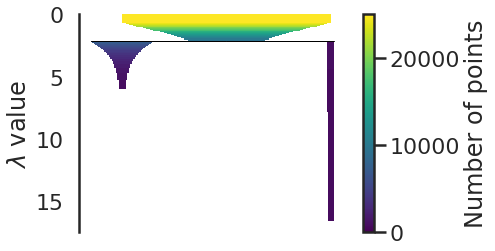

In [0]:
clusterer.condensed_tree_.plot()

/usr/local/lib/python3.6/dist-packages/hdbscan/plots.py:383: UserWarning: Infinite lambda values encountered in chosen clusters. This might be due to duplicates in the data.
  warn('Infinite lambda values encountered in chosen clusters.'


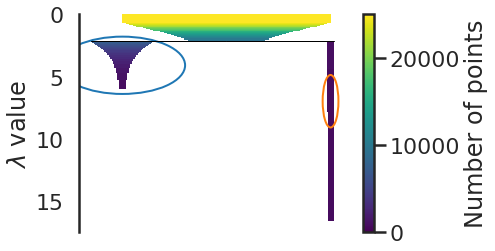

In [0]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [0]:
from sklearn.cluster import AgglomerativeClustering

In [0]:
def create_clusters(df_norm, n_levels):
  df = df_norm.copy()
  cluster = AgglomerativeClustering(n_clusters=n_levels, affinity='euclidean', linkage='ward')
  cluster.fit(df[df.columns[1:]])

  df['cluster'] = cluster.labels_
  df['cluster'] = df['cluster'].apply(lambda x: 'profile_%s' %(x))
  return df, cluster

In [0]:
df_for_clustering_norm = pd.read_csv('data/normalized_user_data.csv')

In [0]:
%%time
df_clust2, cluster2 = create_clusters(df_for_clustering_norm, 12)

CPU times: user 1min 26s, sys: 69 ms, total: 1min 26s
Wall time: 1min 26s


In [0]:
df_clust2.cluster.value_counts()

profile_0     11790
profile_3      3163
profile_7      2095
profile_1      1627
profile_8      1241
profile_11     1185
profile_5      1063
profile_9      1039
profile_6       627
profile_2       619
profile_4       462
profile_10      165
Name: cluster, dtype: int64

In [0]:
%%time
df_clust, cluster = create_clusters(df_for_clustering_norm, 9)

CPU times: user 1min 23s, sys: 51.9 ms, total: 1min 23s
Wall time: 1min 23s


In [0]:
df_clust.cluster.value_counts()

profile_0    12252
profile_4     4348
profile_7     2095
profile_3     1627
profile_8     1241
profile_1     1204
profile_5     1063
profile_6      627
profile_2      619
Name: cluster, dtype: int64

In [0]:
import pandas as pd

In [0]:
df_clust = pd.read_csv('data/df_clust.csv', nrows=10)
df_clust.head()

,u,avg_rating,mode_rating,var_rating,cals,perc_d_fat,perc_d_sugar,perc_d_sodium,perc_d_protein,perc_d_sat_fat,perc_d_carbs,minutes,n_steps,tag__1-day-or-more,tag__15-minutes-or-less,tag__3-steps-or-less,tag__30-minutes-or-less,tag__4-hours-or-less,tag__5-ingredients-or-less,tag__60-minutes-or-less,tag__african,tag__american,tag__appetizers,tag__apples,tag__argentine,tag__asian,tag__asparagus,tag__australian,tag__bacon,tag__bananas,tag__bar-cookies,tag__barbecue,tag__beans,tag__beef,tag__beef-ribs,tag__beef-sausage,tag__beginner-cook,tag__berries,tag__beverages,tag__bisques-cream-soups,...,tag__st-patricks-day,tag__steak,tag__steaks,tag__stews,tag__stir-fry,tag__stove-top,tag__strawberries,tag__summer,tag__super-bowl,tag__superbowl,tag__swedish,tag__sweet,tag__swiss,tag__taste-mood,tag__tex-mex,tag__thai,tag__thanksgiving,tag__tilapia,tag__to-go,tag__toddler-friendly,tag__tomatoes,tag__tropical-fruit,tag__tuna,tag__turkey,tag__turkish,tag__valentines-day,tag__veal,tag__vegan,tag__vegetables,tag__vegetarian,tag__very-low-carbs,tag__vietnamese,tag__water-bath,tag__weeknight,tag__whole-chicken,tag__whole-turkey,tag__winter,tag__yams-sweet-potatoes,tag__yeast,cluster
0,0,0.961290,1.0,0.012903,0.021025,0.028423,0.013915,0.004179,0.032000,0.029955,0.012994,0.000542,0.148538,0.000000,0.027273,0.072727,0.013636,0.027273,0.027273,0.054545,0.000000,0.072727,0.000000,0.022727,0.0,0.027273,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036364,0.000000,0.000000,0.068182,0.027273,0.009091,0.000000,...,0.000000,0.000000,0.022727,0.000000,0.000000,0.027273,0.000000,0.072727,0.000000,0.000000,0.0,0.031818,0.000000,0.109091,0.000000,0.00000,0.040909,0.000000,0.127273,0.000000,0.031818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036364,0.045455,0.040909,0.027273,0.0,0.000000,0.000000,0.031818,0.000000,0.000000,0.000000,0.000000,profile_14
1,1,0.989744,1.0,0.003995,0.020236,0.032202,0.010476,0.003106,0.029913,0.024614,0.010144,0.001472,0.168755,0.000000,0.024194,0.064516,0.024194,0.032258,0.012097,0.048387,0.000000,0.032258,0.016129,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028226,0.048387,0.064516,0.000000,0.000000,0.120968,0.024194,0.000000,0.000000,...,0.000000,0.028226,0.000000,0.032258,0.000000,0.048387,0.000000,0.000000,0.000000,0.000000,0.0,0.028226,0.000000,0.024194,0.040323,0.00000,0.000000,0.000000,0.056452,0.020161,0.028226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032258,0.012097,0.024194,0.0,0.000000,0.012097,0.000000,0.000000,0.072581,0.000000,0.012097,profile_14
2,2,0.844444,0.8,0.020513,0.024548,0.035599,0.020281,0.003856,0.027727,0.031766,0.015883,0.000926,0.157895,0.000000,0.021739,0.043478,0.010870,0.043478,0.000000,0.032609,0.000000,0.130435,0.010870,0.000000,0.0,0.016304,0.000000,0.000000,0.000000,0.076087,0.000000,0.038043,0.021739,0.021739,0.000000,0.000000,0.054348,0.000000,0.010870,0.054348,...,0.000000,0.000000,0.000000,0.043478,0.000000,0.032609,0.000000,0.086957,0.000000,0.000000,0.0,0.038043,0.000000,0.195652,0.054348,0.00000,0.000000,0.000000,0.152174,0.000000,0.038043,0.065217,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.054348,0.048913,0.000000,0.0,0.000000,0.005435,0.000000,0.000000,0.000000,0.000000,0.000000,profile_1
3,3,0.964309,1.0,0.018932,0.024385,0.034220,0.019454,0.003820,0.036677,0.028797,0.014714,0.002200,0.164559,0.001811,0.024860,0.039183,0.016958,0.031775,0.037784,0.044946,0.002881,0.046098,0.012348,0.006997,0.0,0.012348,0.001482,0.008643,0.002881,0.005762,0.006585,0.011525,0.011525,0.025354,0.001976,0.001235,0.053507,0.010372,0.005762,0.004116,...,0.004445,0.001152,0.001646,0.002634,0.006915,0.070629,0.007244,0.028317,0.000000,0.010866,0.0,0.029388,0.000905,0.122983,0.003293,0.00247,0.011113,0.001152,0.057623,0.009467,0.011525,0.012842,0.002881,0.003704,0.003787,0.011854,0.000000,0.017781,0.038031,0.033339,0.018275,0.0,0.002963,0.007820,0.001152,0.001317,0.024448,0.002963,0.002716,profile_14
4,4,0.877660,1.0,0.0

In [0]:
# df_clust.to_csv('data/df_clust_9.csv', index=False) #HEEEEEREEEEEE

In [0]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy

In [0]:
%%time
color_pal = ['#69F8E4', '#FBFBA8', '#D5C1F1', '#F46B55', '#558DF4',
'#F4B555', '#CEF455', '#F583EA', '#9D999D', '#64115D',
'#116416', '#E2CB07', '#3846F4', '#070707', '#FC027F',
'#02FCFC', '#28FC02', '#A25715', '#A21591', '#8BE0F7']


Z = linkage(df_for_clustering_norm[1:], 'ward')

CPU times: user 1min 28s, sys: 52.9 ms, total: 1min 28s
Wall time: 1min 28s


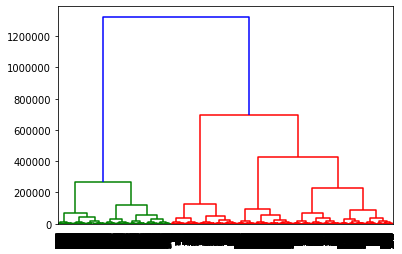

In [0]:
plt.figure()
dn = hierarchy.dendrogram(Z)
plt.show()

In [0]:
# Create a color palette with 3 color for the 3 cyl possibilities
my_palette = plt.cm.get_cmap("Accent", 3)
 
# transforme the 'cyl' column in a categorical variable. It will allow to put one color on each level.
df['cyl']=pd.Categorical(df['cyl'])
my_color=df['cyl'].cat.codes
 
# Apply the right color to each label
ax = plt.gca()
xlbls = ax.get_ymajorticklabels()
num=-1
for lbl in xlbls:
num+=1
val=my_color[num]
lbl.set_color(my_palette(val))

In [0]:
df_for_clustering_norm

,u,avg_rating,mode_rating,var_rating,cals,perc_d_fat,perc_d_sugar,perc_d_sodium,perc_d_protein,perc_d_sat_fat,perc_d_carbs,minutes,n_steps,tag__1-day-or-more,tag__15-minutes-or-less,tag__3-steps-or-less,tag__30-minutes-or-less,tag__4-hours-or-less,tag__5-ingredients-or-less,tag__60-minutes-or-less,tag__african,tag__american,tag__appetizers,tag__apples,tag__argentine,tag__asian,tag__asparagus,tag__australian,tag__bacon,tag__bananas,tag__bar-cookies,tag__barbecue,tag__beans,tag__beef,tag__beef-ribs,tag__beef-sausage,tag__beginner-cook,tag__berries,tag__beverages,tag__bisques-cream-soups,...,tag__squash,tag__st-patricks-day,tag__steak,tag__steaks,tag__stews,tag__stir-fry,tag__stove-top,tag__strawberries,tag__summer,tag__super-bowl,tag__superbowl,tag__swedish,tag__sweet,tag__swiss,tag__taste-mood,tag__tex-mex,tag__thai,tag__thanksgiving,tag__tilapia,tag__to-go,tag__toddler-friendly,tag__tomatoes,tag__tropical-fruit,tag__tuna,tag__turkey,tag__turkish,tag__valentines-day,tag__veal,tag__vegan,tag__vegetables,tag__vegetarian,tag__very-low-carbs,tag__vietnamese,tag__water-bath,tag__weeknight,tag__whole-chicken,tag__whole-turkey,tag__winter,tag__yams-sweet-potatoes,tag__yeast
0,0,0.961290,1.0,0.012903,0.021025,0.028423,0.013915,0.004179,0.032000,0.029955,0.012994,0.000542,0.148538,0.000000,0.027273,0.072727,0.013636,0.027273,0.027273,0.054545,0.000000,0.072727,0.000000,0.022727,0.0,0.027273,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036364,0.000000,0.000000,0.068182,0.027273,0.009091,0.000000,...,0.000000,0.000000,0.000000,0.022727,0.000000,0.000000,0.027273,0.000000,0.072727,0.000000,0.000000,0.0,0.031818,0.000000,0.109091,0.000000,0.00000,0.040909,0.000000,0.127273,0.000000,0.031818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036364,0.045455,0.040909,0.027273,0.0,0.000000,0.000000,0.031818,0.000000,0.000000,0.000000,0.000000
1,1,0.989744,1.0,0.003995,0.020236,0.032202,0.010476,0.003106,0.029913,0.024614,0.010144,0.001472,0.168755,0.000000,0.024194,0.064516,0.024194,0.032258,0.012097,0.048387,0.000000,0.032258,0.016129,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028226,0.048387,0.064516,0.000000,0.000000,0.120968,0.024194,0.000000,0.000000,...,0.000000,0.000000,0.028226,0.000000,0.032258,0.000000,0.048387,0.000000,0.000000,0.000000,0.000000,0.0,0.028226,0.000000,0.024194,0.040323,0.00000,0.000000,0.000000,0.056452,0.020161,0.028226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032258,0.012097,0.024194,0.0,0.000000,0.012097,0.000000,0.000000,0.072581,0.000000,0.012097
2,2,0.844444,0.8,0.020513,0.024548,0.035599,0.020281,0.003856,0.027727,0.031766,0.015883,0.000926,0.157895,0.000000,0.021739,0.043478,0.010870,0.043478,0.000000,0.032609,0.000000,0.130435,0.010870,0.000000,0.0,0.016304,0.000000,0.000000,0.000000,0.076087,0.000000,0.038043,0.021739,0.021739,0.000000,0.000000,0.054348,0.000000,0.010870,0.054348,...,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.032609,0.000000,0.086957,0.000000,0.000000,0.0,0.038043,0.000000,0.195652,0.054348,0.00000,0.000000,0.000000,0.152174,0.000000,0.038043,0.065217,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.054348,0.048913,0.000000,0.0,0.000000,0.005435,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0.964309,1.0,0.018932,0.024385,0.034220,0.019454,0.003820,0.036677,0.028797,0.014714,0.002200,0.164559,0.001811,0.024860,0.039183,0.016958,0.031775,0.037784,0.044946,0.002881,0.046098,0.012348,0.006997,0.0,0.012348,0.001482,0.008643,0.002881,0.005762,0.006585,0.011525,0.011525,0.025354,0.001976,0.001235,0.053507,0.010372,0.005762,0.004116,...,0.003951,0.004445,0.001152,0.001646,0.002634,0.006915,0.070629,0.007244,0.028317,0.000000,0.010866,0.0,0.029388,0.000905,0.122983,0.003293,0.00247,0.011113,0.001152,0.057623,0.009467,0.011525,0.012842,0.002881,0.003704,0.003787,0.011854,0.000000,0.017781,0.038031,0.033339,0.018275,0.0,0.002963,0.007820,0.001152,0.001317,0.024448,0.002963,0.002716
4,4,0.877660,1.0,0.0728

In [0]:
df_clust.cluster.value_counts()

profile_14    7876
profile_1     3163
profile_7     2095
profile_0     1481
profile_3     1241
profile_11    1185
profile_8     1128
profile_12    1063
profile_19    1056
profile_9     1039
profile_6      627
profile_16     550
profile_15     499
profile_2      476
profile_4      462
profile_13     376
profile_5      273
profile_18     178
profile_10     165
profile_17     143
Name: cluster, dtype: int64

In [0]:
from matplotlib import colors

def b_g(s, cmap='PuBu', low=0, high=0):
    # Pass the columns from Dataframe A 
    a = A.loc[:,s.name].copy()
    rng = a.max() - a.min()
    norm = colors.Normalize(a.min() - (rng * low),
                        a.max() + (rng * high))
    normed = norm(a.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

In [0]:
# A = pd.DataFrame(np.random.randn(6, 3), columns=['a', 'b', 'c']) 
# B = pd.DataFrame(np.random.randn(6, 3), columns=['a', 'b', 'c'])

In [0]:
B.style.apply(b_g,cmap='Wistia')

In [0]:
A = df_clust[df_clust.columns[1:]].groupby('cluster').mean()#.style.apply(lambda x: ["background-color: %s" % v for v in x], axis = 1)
B = A

In [0]:
A.to_csv('data/cluster_info.csv', index=False)

In [0]:
import scipy.cluster.hierarchy as sch

In [0]:
?sch.dendrogram

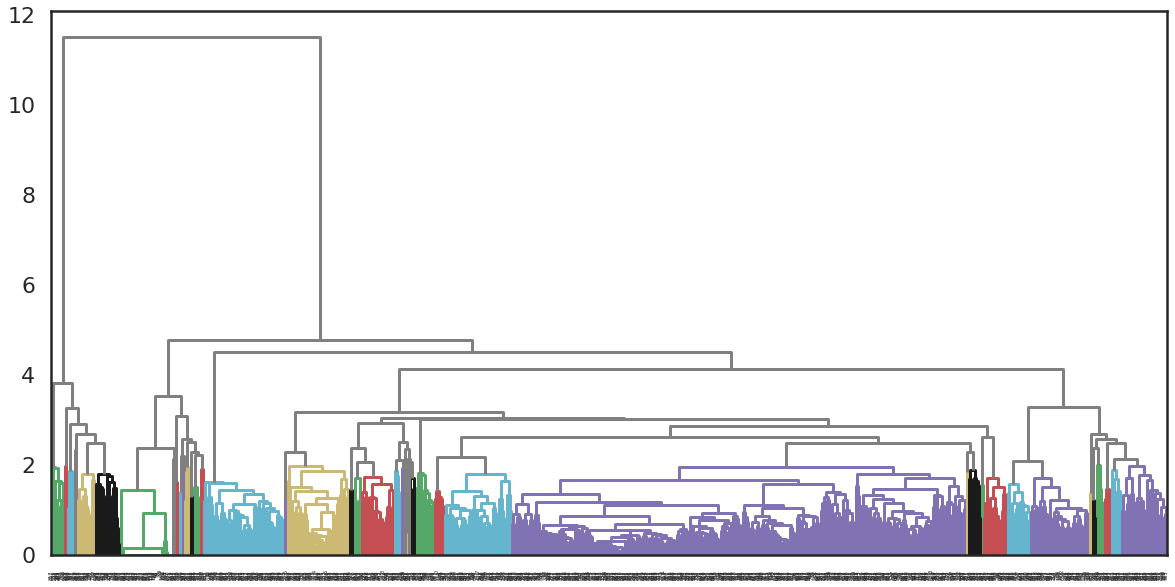

In [0]:
df_try = df_for_clustering_norm.sample(n=1000, random_state=123)
fig, ax = plt.subplots(figsize=(20,10))
dendrogram = sch.dendrogram(sch.linkage(df_try[df_try.columns[1:]], method='ward'), color_threshold=2, above_threshold_color='grey')

In [0]:
df_clust.head()

,u,avg_rating,mode_rating,var_rating,cals,perc_d_fat,perc_d_sugar,perc_d_sodium,perc_d_protein,perc_d_sat_fat,perc_d_carbs,minutes,n_steps,tag__1-day-or-more,tag__15-minutes-or-less,tag__3-steps-or-less,tag__30-minutes-or-less,tag__4-hours-or-less,tag__5-ingredients-or-less,tag__60-minutes-or-less,tag__african,tag__american,tag__appetizers,tag__apples,tag__argentine,tag__asian,tag__asparagus,tag__australian,tag__bacon,tag__bananas,tag__bar-cookies,tag__barbecue,tag__beans,tag__beef,tag__beef-ribs,tag__beef-sausage,tag__beginner-cook,tag__berries,tag__beverages,tag__bisques-cream-soups,...,tag__st-patricks-day,tag__steak,tag__steaks,tag__stews,tag__stir-fry,tag__stove-top,tag__strawberries,tag__summer,tag__super-bowl,tag__superbowl,tag__swedish,tag__sweet,tag__swiss,tag__taste-mood,tag__tex-mex,tag__thai,tag__thanksgiving,tag__tilapia,tag__to-go,tag__toddler-friendly,tag__tomatoes,tag__tropical-fruit,tag__tuna,tag__turkey,tag__turkish,tag__valentines-day,tag__veal,tag__vegan,tag__vegetables,tag__vegetarian,tag__very-low-carbs,tag__vietnamese,tag__water-bath,tag__weeknight,tag__whole-chicken,tag__whole-turkey,tag__winter,tag__yams-sweet-potatoes,tag__yeast,cluster
0,0,0.961290,1.0,0.012903,0.021025,0.028423,0.013915,0.004179,0.032000,0.029955,0.012994,0.000542,0.148538,0.000000,0.027273,0.072727,0.013636,0.027273,0.027273,0.054545,0.000000,0.072727,0.000000,0.022727,0.0,0.027273,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036364,0.000000,0.000000,0.068182,0.027273,0.009091,0.000000,...,0.000000,0.000000,0.022727,0.000000,0.000000,0.027273,0.000000,0.072727,0.000000,0.000000,0.0,0.031818,0.000000,0.109091,0.000000,0.00000,0.040909,0.000000,0.127273,0.000000,0.031818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036364,0.045455,0.040909,0.027273,0.0,0.000000,0.000000,0.031818,0.000000,0.000000,0.000000,0.000000,profile_14
1,1,0.989744,1.0,0.003995,0.020236,0.032202,0.010476,0.003106,0.029913,0.024614,0.010144,0.001472,0.168755,0.000000,0.024194,0.064516,0.024194,0.032258,0.012097,0.048387,0.000000,0.032258,0.016129,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028226,0.048387,0.064516,0.000000,0.000000,0.120968,0.024194,0.000000,0.000000,...,0.000000,0.028226,0.000000,0.032258,0.000000,0.048387,0.000000,0.000000,0.000000,0.000000,0.0,0.028226,0.000000,0.024194,0.040323,0.00000,0.000000,0.000000,0.056452,0.020161,0.028226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032258,0.012097,0.024194,0.0,0.000000,0.012097,0.000000,0.000000,0.072581,0.000000,0.012097,profile_14
2,2,0.844444,0.8,0.020513,0.024548,0.035599,0.020281,0.003856,0.027727,0.031766,0.015883,0.000926,0.157895,0.000000,0.021739,0.043478,0.010870,0.043478,0.000000,0.032609,0.000000,0.130435,0.010870,0.000000,0.0,0.016304,0.000000,0.000000,0.000000,0.076087,0.000000,0.038043,0.021739,0.021739,0.000000,0.000000,0.054348,0.000000,0.010870,0.054348,...,0.000000,0.000000,0.000000,0.043478,0.000000,0.032609,0.000000,0.086957,0.000000,0.000000,0.0,0.038043,0.000000,0.195652,0.054348,0.00000,0.000000,0.000000,0.152174,0.000000,0.038043,0.065217,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.054348,0.048913,0.000000,0.0,0.000000,0.005435,0.000000,0.000000,0.000000,0.000000,0.000000,profile_1
3,3,0.964309,1.0,0.018932,0.024385,0.034220,0.019454,0.003820,0.036677,0.028797,0.014714,0.002200,0.164559,0.001811,0.024860,0.039183,0.016958,0.031775,0.037784,0.044946,0.002881,0.046098,0.012348,0.006997,0.0,0.012348,0.001482,0.008643,0.002881,0.005762,0.006585,0.011525,0.011525,0.025354,0.001976,0.001235,0.053507,0.010372,0.005762,0.004116,...,0.004445,0.001152,0.001646,0.002634,0.006915,0.070629,0.007244,0.028317,0.000000,0.010866,0.0,0.029388,0.000905,0.122983,0.003293,0.00247,0.011113,0.001152,0.057623,0.009467,0.011525,0.012842,0.002881,0.003704,0.003787,0.011854,0.000000,0.017781,0.038031,0.033339,0.018275,0.0,0.002963,0.007820,0.001152,0.001317,0.024448,0.002963,0.002716,profile_14
4,4,0.877660,1.0,0.0

In [0]:
import matplotlib.pyplot as plt

In [0]:
from mpl_toolkits import mplot3d

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


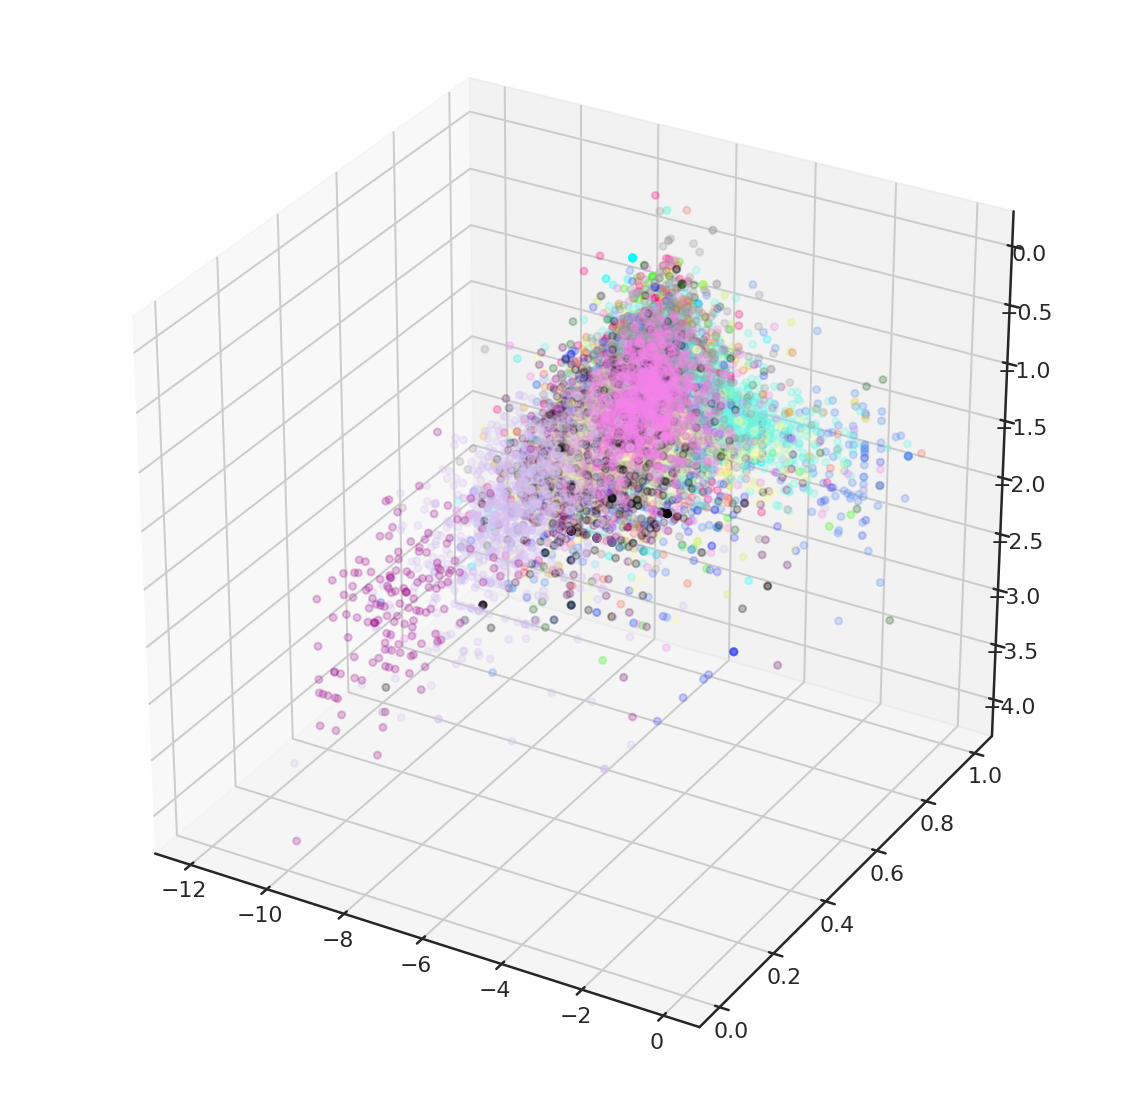

In [0]:
fig, ax = plt.subplots(figsize=(20,20))
ax = plt.axes(projection='3d')
color_pal = ['#69F8E4', '#FBFBA8', '#D5C1F1', '#F46B55', '#558DF4',
'#F4B555', '#CEF455', '#F583EA', '#9D999D', '#64115D',
'#116416', '#E2CB07', '#3846F4', '#070707', '#FC027F',
'#02FCFC', '#28FC02', '#A25715', '#A21591', '#8BE0F7']

for label, c_color in zip(list(df_clust.cluster.unique()), color_pal):
  ax.scatter(np.log(df_clust[df_clust.cluster == label]['minutes']), 
                df_clust[df_clust.cluster == label]['avg_rating'], 
                np.log(df_clust[df_clust.cluster == label]['n_steps']), 
              s=50, marker='o', c=c_color, alpha=.25)
plt.show()

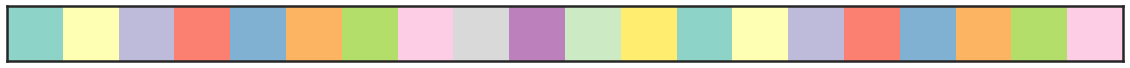

In [0]:
sns.palplot(sns.color_palette("Set3", 20))